In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from scipy.ndimage import gaussian_filter   # For smoothing


In [27]:
# 1) LOAD DATA

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [28]:
# 2) FILTER ONLY 3 CLASSES

# Bag = 8 , Trouser = 1 , Sneaker = 7
keep_classes = [8, 1, 7]

train_mask = np.isin(y_train, keep_classes)
test_mask = np.isin(y_test, keep_classes)

X_train = X_train[train_mask]
y_train = y_train[train_mask]

X_test = X_test[test_mask]
y_test = y_test[test_mask]

In [29]:
# 3) PREPROCESSING

# A) Normalize to [0,1]
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

# B) Remove noise using Gaussian smoothing
X_train_smooth = np.array([gaussian_filter(img, sigma=0.7) for img in X_train_norm])
X_test_smooth  = np.array([gaussian_filter(img, sigma=0.7) for img in X_test_norm])

# C) Flatten
X_train_flat = X_train_smooth.reshape(-1, 784)
X_test_flat = X_test_smooth.reshape(-1, 784)

# D) Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (18000, 28, 28)
Test size: (3000, 28, 28)


In [30]:
# 4) LOGISTIC REGRESSION
import warnings
log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    multi_class="multinomial"
)

log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

print("\nLogistic Regression Train Acc:", accuracy_score(y_train, log_reg.predict(X_train_scaled)))
print("Logistic Regression Test Acc :", accuracy_score(y_test, y_pred_lr))


c:\Users\ok\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Train Acc: 0.9997222222222222
Logistic Regression Test Acc : 0.993


In [31]:
# 5) K-MEANS
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_scaled)

clusters = kmeans.predict(X_test_scaled)

# Map each cluster → class
label_map = {}
for cluster in range(3):
    labels = y_train[kmeans.labels_ == cluster]
    label_map[cluster] = np.bincount(labels).argmax() if len(labels) > 0 else 0

y_pred_kmeans = np.array([label_map[c] for c in clusters])

print("\nK-Means Test Accuracy:", accuracy_score(y_test, y_pred_kmeans))



K-Means Test Accuracy: 0.9173333333333333


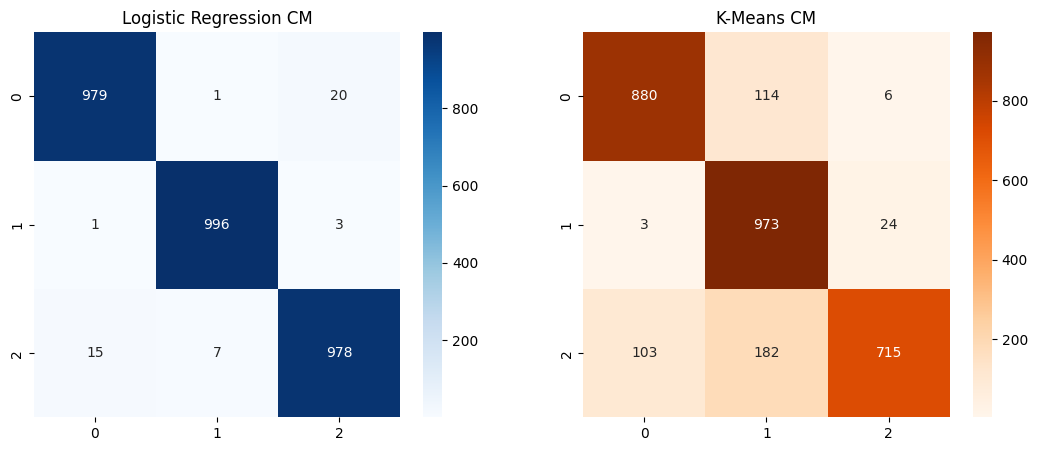

In [16]:
# 6) CONFUSION MATRICES
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), cmap="Blues", annot=True, fmt="d")
plt.title("Logistic Regression CM")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_kmeans), cmap="Oranges", annot=True, fmt="d")
plt.title("K-Means CM")

plt.show()

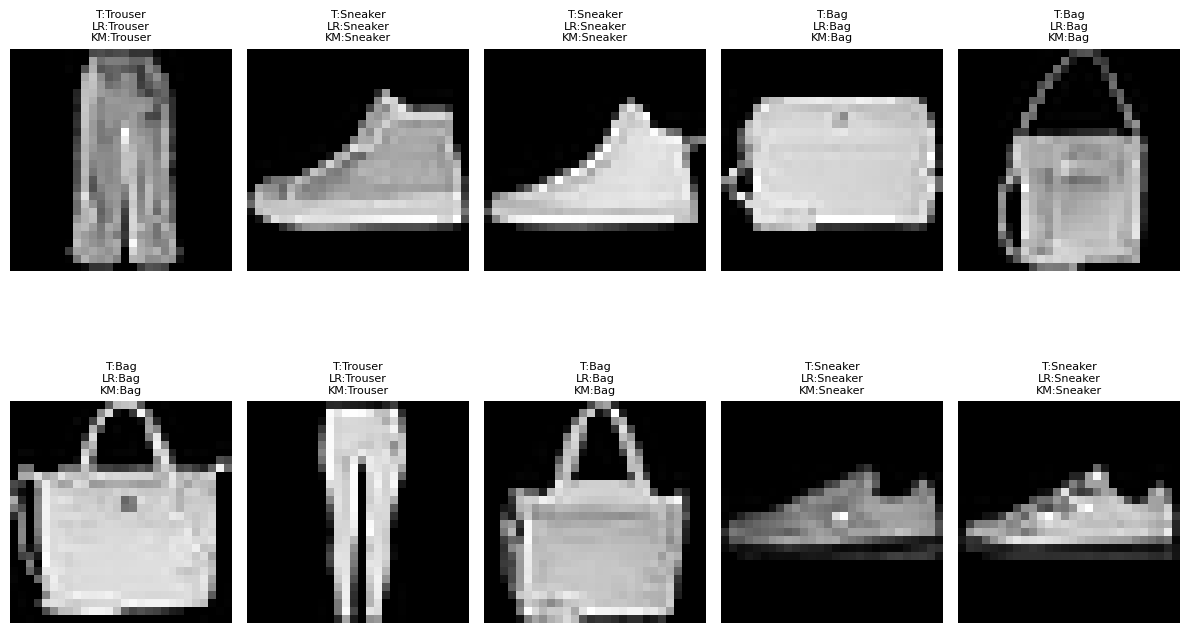

In [32]:
# 7) VISUALIZE PREDICTIONS
class_names = {8: "Bag", 1: "Trouser", 7: "Sneaker"}

plt.figure(figsize=(12,8))
for i in range(10):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.axis('off')

    true_lbl = class_names[y_test[idx]]
    lr_lbl = class_names[y_pred_lr[idx]]
    km_lbl = class_names[y_pred_kmeans[idx]]

    plt.title(f"T:{true_lbl}\nLR:{lr_lbl}\nKM:{km_lbl}", fontsize=8)

plt.tight_layout()
plt.show()